Notebook to predict the basis points for mututal funds.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import statsmodels.api as sm

plt.style.use('ggplot')

In [3]:
mdf = pd.read_csv('Yes_Bank_Train.csv', encoding='palmos')

In [4]:
mdf.head()

,Serial Number,fund_symbol,fund_name,category,fund_family,investment,size,total_net_assets,currency,net_annual_expenses_ratio,...,returns_2012,returns_2011,returns_2010,morningstar_risk_rating,alpha_3y,beta_3y,mean_annual_return_3y,standard_deviation_3y,sharpe_ratio_3y,treynor_ratio_3y
0,1,AAAAX,Deutsche Real Assets A,World Allocation,Deutsche Asset Management,Blend,Large,486740000,USD,1.22,...,9.32,-3.46,12.20,3,-1.96,0.84,0.26,7.16,0.35,2.70
1,2,AAADX,Aberdeen Income Builder A,Large Blend,Aberdeen,Value,Large,9980000,USD,1.44,...,NaN,NaN,NaN,3,-4.84,1.00,0.51,10.62,0.51,5.04
2,3,AAAGX,Thrivent Large Cap Growth A,Large Growth,Thrivent,Growth,Large,997620000,USD,1.20,...,17.79,-6.29,9.70,4,1.04,1.10,1.08,12.91,0.96,11.15
3,4,AAAIX,American Century Strat Allc: Agrsv I,Allocation--70% to 85% Equity,American Century Investments,Growth,Large,907850000,USD,0.91,...,15.09,-1.67,15.62,3,-0.77,1.34,0.59,8.61,0.74,4.60
4,5,AAANX,Horizon Active Asset Allocation Investor,Tactical Allocation,Horizon Investments,Blend,Large,451260000,USD,1.36,...,NaN,NaN,NaN,4,-1.87,1.64,0.62,10.79,0.63,3.94


In [5]:
mdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17773 entries, 0 to 17772
Data columns (total 56 columns):
Serial Number                     17773 non-null int64
fund_symbol                       17773 non-null object
fund_name                         17773 non-null object
category                          17773 non-null object
fund_family                       17773 non-null object
investment                        16783 non-null object
size                              16783 non-null object
total_net_assets                  17773 non-null int64
currency                          17773 non-null object
net_annual_expenses_ratio         17761 non-null float64
morningstar_rating                17773 non-null int64
inception_date                    17773 non-null object
portfolio_cash                    17768 non-null float64
portfolio_stocks                  17768 non-null float64
portfolio_bonds                   17768 non-null float64
portfolio_others                  17768 non-null f

In [6]:
mdf.shape

(17773, 56)

In [7]:
# Removing rows and columns which have all null values
mdf.dropna(axis = 1, how = 'all', inplace = True)
mdf.dropna(how='all', inplace=True)
mdf.shape

(17773, 56)

In [8]:
round(mdf.isnull().sum()*100/len(mdf),2)

Serial Number                      0.00
fund_symbol                        0.00
fund_name                          0.00
category                           0.00
fund_family                        0.00
investment                         5.57
size                               5.57
total_net_assets                   0.00
currency                           0.00
net_annual_expenses_ratio          0.07
morningstar_rating                 0.00
inception_date                     0.00
portfolio_cash                     0.03
portfolio_stocks                   0.03
portfolio_bonds                    0.03
portfolio_others                   0.03
portfolio_preferred                0.03
portfolio_convertable              0.03
sectors_basic_materials            0.03
sectors_consumer_cyclical          0.03
sectors_financial_services         0.03
sectors_real_estate                0.03
sectors_consumer_defensive         0.03
sectors_healthcare                 0.03
sectors_utilities                  0.03


In [9]:
def impute_with_mode(data, cols):
    for column in cols:
        data[column].fillna(data[column].mode()[0], inplace=True)

In [10]:
impute_with_mode(mdf, ['investment','size'])

In [11]:
mdf[['portfolio_cash','portfolio_stocks','portfolio_bonds','portfolio_others','portfolio_preferred','portfolio_convertable','sectors_basic_materials','sectors_consumer_cyclical','sectors_financial_services','sectors_real_estate','sectors_consumer_defensive','sectors_healthcare','sectors_utilities','sectors_communication_services','sectors_energy','sectors_industrials','sectors_technology','price_earning','bonds_us_government','bonds_aaa','bonds_aa','bonds_a','bonds_bbb','bonds_bb','bonds_b','bonds_below_b','bonds_others']].isnull().sum()

portfolio_cash                    5
portfolio_stocks                  5
portfolio_bonds                   5
portfolio_others                  5
portfolio_preferred               5
portfolio_convertable             5
sectors_basic_materials           5
sectors_consumer_cyclical         5
sectors_financial_services        5
sectors_real_estate               5
sectors_consumer_defensive        5
sectors_healthcare                5
sectors_utilities                 5
sectors_communication_services    5
sectors_energy                    5
sectors_industrials               5
sectors_technology                5
price_earning                     5
bonds_us_government               5
bonds_aaa                         5
bonds_aa                          5
bonds_a                           5
bonds_bbb                         5
bonds_bb                          5
bonds_b                           5
bonds_below_b                     5
bonds_others                      5
dtype: int64

In [12]:
mdf = mdf[np.isfinite(mdf['bonds_aaa'])]

In [13]:
CAT = 'categorical'
NUM = 'numerical'

def get_col_type(col):
    cols = mdf.columns
    num_cols = mdf._get_numeric_data().columns
    if(col in num_cols):
        if('night_pck'==col[0:9] or 'fb_user'==col[0:7]):
            return CAT
        else:
            return NUM
    else:
        return CAT
    
def generate_null_dataframe(data):
    null_df = pd.DataFrame(data.isnull().sum()*100/len(data), columns=['na_perc'])
    null_df['column'] = null_df.index
    null_df.index = range(0,len(null_df['column']))
    null_df['col_type'] = null_df['column'].map(get_col_type)
    null_df = null_df[null_df.na_perc > 0]
    return null_df

In [15]:
from fancyimpute import KNN
from concurrent.futures import ThreadPoolExecutor

executor = ThreadPoolExecutor(max_workers=30)
data_num = mdf[mdf._get_numeric_data().columns]
def knn_impute(i,j,data_num):
    data_num.iloc[j:i] = KNN(k=10, verbose=False).complete(data_num.iloc[j:i])
j=0
for i in range(1000,len(data_num),1000):
    executor.submit(knn_impute,i,j,data_num)
    j = i
executor.shutdown(wait=True)

D:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
D:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
D:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_

In [16]:
data_num.shape

(17768, 48)

In [17]:
mdf.shape

(17768, 56)

In [18]:
mdf.loc[:,['net_annual_expenses_ratio','returns_ytd','returns_2017','returns_2016','returns_2015','returns_2014','returns_2013','returns_2012','returns_2011','returns_2010','alpha_3y','beta_3y','mean_annual_return_3y','standard_deviation_3y','sharpe_ratio_3y','treynor_ratio_3y']]=data_num.loc[:,['net_annual_expenses_ratio','returns_ytd','returns_2017','returns_2016','returns_2015','returns_2014','returns_2013','returns_2012','returns_2011','returns_2010','alpha_3y','beta_3y','mean_annual_return_3y','standard_deviation_3y','sharpe_ratio_3y','treynor_ratio_3y']]

In [19]:
mdf.head()

,Serial Number,fund_symbol,fund_name,category,fund_family,investment,size,total_net_assets,currency,net_annual_expenses_ratio,...,returns_2012,returns_2011,returns_2010,morningstar_risk_rating,alpha_3y,beta_3y,mean_annual_return_3y,standard_deviation_3y,sharpe_ratio_3y,treynor_ratio_3y
0,1,AAAAX,Deutsche Real Assets A,World Allocation,Deutsche Asset Management,Blend,Large,486740000,USD,1.22,...,9.320000,-3.460000,12.200000,3,-1.96,0.84,0.26,7.16,0.35,2.70
1,2,AAADX,Aberdeen Income Builder A,Large Blend,Aberdeen,Value,Large,9980000,USD,1.44,...,12.640002,0.639997,13.940002,3,-4.84,1.00,0.51,10.62,0.51,5.04
2,3,AAAGX,Thrivent Large Cap Growth A,Large Growth,Thrivent,Growth,Large,997620000,USD,1.20,...,17.790000,-6.290000,9.700000,4,1.04,1.10,1.08,12.91,0.96,11.15
3,4,AAAIX,American Century Strat Allc: Agrsv I,Allocation--70% to 85% Equity,American Century Investments,Growth,Large,907850000,USD,0.91,...,15.090000,-1.670000,15.620000,3,-0.77,1.34,0.59,8.61,0.74,4.60
4,5,AAANX,Horizon Active Asset Allocation Investor,Tactical Allocation,Horizon Investments,Blend,Large,451260000,USD,1.36,...,16.941936,-11.910626,15.850406,4,-1.87,1.64,0.62,10.79,0.63,3.94


In [20]:
mdf = mdf[np.isfinite(mdf['net_annual_expenses_ratio'])]

In [21]:
round(mdf.isnull().sum()*100/len(mdf),2)

Serial Number                     0.00
fund_symbol                       0.00
fund_name                         0.00
category                          0.00
fund_family                       0.00
investment                        0.00
size                              0.00
total_net_assets                  0.00
currency                          0.00
net_annual_expenses_ratio         0.00
morningstar_rating                0.00
inception_date                    0.00
portfolio_cash                    0.00
portfolio_stocks                  0.00
portfolio_bonds                   0.00
portfolio_others                  0.00
portfolio_preferred               0.00
portfolio_convertable             0.00
sectors_basic_materials           0.00
sectors_consumer_cyclical         0.00
sectors_financial_services        0.00
sectors_real_estate               0.00
sectors_consumer_defensive        0.00
sectors_healthcare                0.00
sectors_utilities                 0.00
sectors_communication_ser

In [22]:
mdf_non_na = mdf.dropna(axis=0, how='any')

In [23]:
round(mdf_non_na.isnull().sum()*100/len(mdf),2)

Serial Number                     0.0
fund_symbol                       0.0
fund_name                         0.0
category                          0.0
fund_family                       0.0
investment                        0.0
size                              0.0
total_net_assets                  0.0
currency                          0.0
net_annual_expenses_ratio         0.0
morningstar_rating                0.0
inception_date                    0.0
portfolio_cash                    0.0
portfolio_stocks                  0.0
portfolio_bonds                   0.0
portfolio_others                  0.0
portfolio_preferred               0.0
portfolio_convertable             0.0
sectors_basic_materials           0.0
sectors_consumer_cyclical         0.0
sectors_financial_services        0.0
sectors_real_estate               0.0
sectors_consumer_defensive        0.0
sectors_healthcare                0.0
sectors_utilities                 0.0
sectors_communication_services    0.0
sectors_ener

In [24]:
mdf_non_na.shape

(17434, 56)

In [25]:
mdf.shape

(17756, 56)

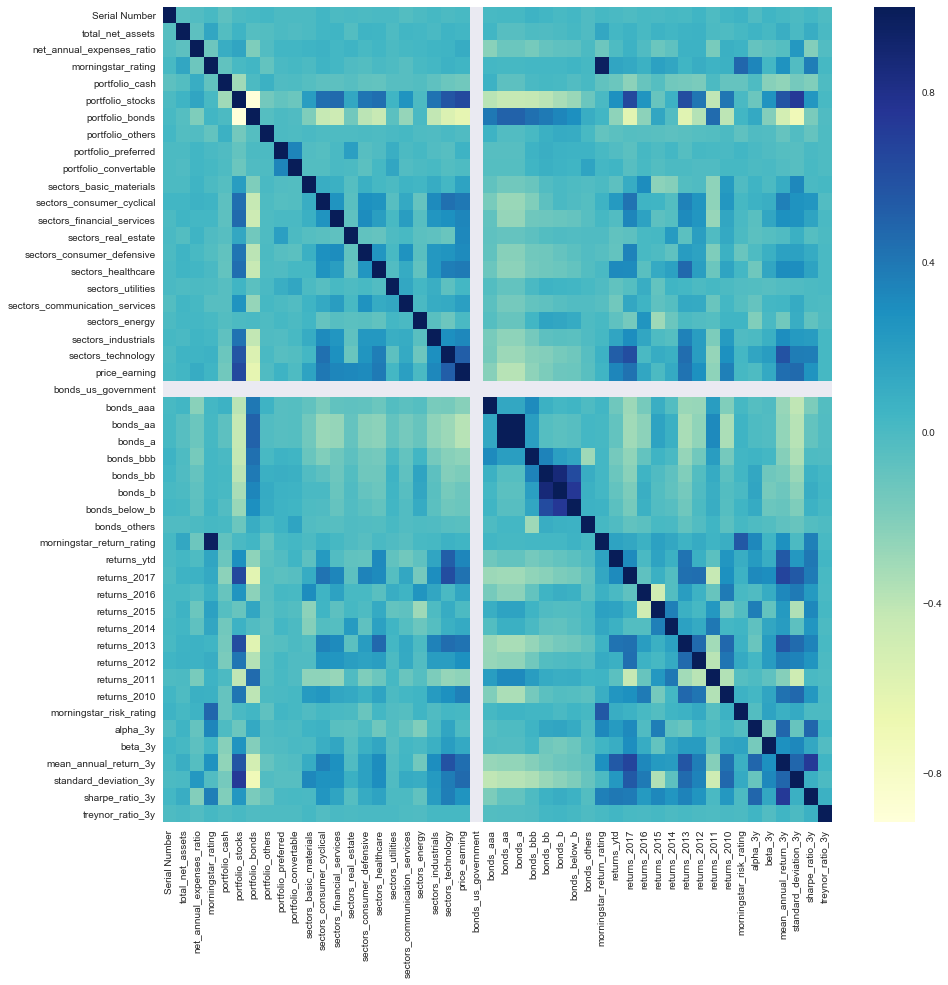

In [26]:
plt.figure(figsize=(15,15))
# Create correlation matrix
corr = mdf_non_na.corr()
sns.set(font_scale=1)
sns.heatmap(corr, cmap="YlGnBu", annot=False)

In [27]:
mdf_non_na.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17434 entries, 0 to 17767
Data columns (total 56 columns):
Serial Number                     17434 non-null int64
fund_symbol                       17434 non-null object
fund_name                         17434 non-null object
category                          17434 non-null object
fund_family                       17434 non-null object
investment                        17434 non-null object
size                              17434 non-null object
total_net_assets                  17434 non-null int64
currency                          17434 non-null object
net_annual_expenses_ratio         17434 non-null float64
morningstar_rating                17434 non-null int64
inception_date                    17434 non-null object
portfolio_cash                    17434 non-null float64
portfolio_stocks                  17434 non-null float64
portfolio_bonds                   17434 non-null float64
portfolio_others                  17434 non-null f

In [28]:
cols = mdf.columns
num_cols = mdf._get_numeric_data().columns
cats = cols.difference(num_cols)
cats

Index(['category', 'currency', 'fund_family', 'fund_name', 'fund_symbol',
       'inception_date', 'investment', 'size'],
      dtype='object')

## Converting categorical features to numerical for linear regression.

Drop currency as it is same for all rows

In [29]:
mdf_non_na.drop('currency',axis=1,inplace=True)

D:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


### One hot encoding for categorical columns with less cardinality

In [30]:
cols_to_transform = ['investment', 'size']
mdf_num = pd.get_dummies( data = mdf_non_na, columns = cols_to_transform ,drop_first=True)

In [31]:
mdf_num.shape

(17434, 57)

category, fund_family, fund_name, fund_symbol, inception_date is left

fund name and fund symbol have different values for each row so dropping them since they don't add much value

In [32]:
mdf_num.inception_date.nunique()

3392

In [33]:
mdf_num.drop(columns=['fund_name','fund_symbol'], axis=1, inplace=True)

In [34]:
from sklearn.preprocessing import LabelEncoder

lb_category = LabelEncoder()
lb_fund_family = LabelEncoder()
mdf_num["category"] = lb_category.fit_transform(mdf_num["category"])
mdf_num["fund_family"] = lb_fund_family.fit_transform(mdf_num["fund_family"])

Lets convert the inception date as the offset from the earliest date

In [35]:
mdf_num["inception_date"] = pd.to_datetime(mdf_num["inception_date"])

In [36]:
mdf_num["inception_date"].min()

Timestamp('1924-07-14 00:00:00')

In [37]:
from datetime import datetime
import math
def convert_to_date_delta(d):
    start_date = datetime(1924,7,7)
    delta = (d-start_date).days
    return delta

In [38]:
mdf_num["inception_date_delta"] = mdf_num["inception_date"].apply(lambda x: convert_to_date_delta(x))

In [39]:
mdf_num.drop('inception_date', axis=1, inplace=True)

## Read in test data and see what columns are missing in test data

In [40]:
mdf_test = pd.read_csv('Yes_Bank_Test_Data.csv', encoding='palmos')

In [41]:
mdf_test.columns.difference(mdf_num.columns)

Index(['currency', 'fund_name', 'fund_symbol', 'inception_date', 'investment',
       'net_annual_expenses', 'size'],
      dtype='object')

In [42]:
mdf_num.drop(['bonds_a', 'bonds_aa', 'bonds_b', 'bonds_bb', 'bonds_bbb',
       'bonds_below_b', 'bonds_others'], inplace=True, axis=1)

In [43]:
mdf_test["inception_date"] = pd.to_datetime(mdf_test["inception_date"])

In [44]:
mdf_test.rename(columns={'net_annual_expenses':'net_annual_expenses_ratio'}, inplace=True)

In [45]:
mdf_test["inception_date_delta"] = mdf_test["inception_date"].apply(lambda x: convert_to_date_delta(x))

In [46]:
mdf_test.drop('inception_date', axis=1, inplace=True)

In [47]:
mdf_test.drop('currency',axis=1,inplace=True)

### One hot encoding for categorical columns with less cardinality

In [48]:
cols_to_transform = ['investment', 'size']
mdf_test = pd.get_dummies( data = mdf_test, columns = cols_to_transform ,drop_first=True)

In [49]:
mdf_test["category"] = lb_category.fit_transform(mdf_test["category"])
mdf_test["fund_family"] = lb_fund_family.fit_transform(mdf_test["fund_family"])

In [50]:
mdf_test.drop(['fund_name', 'fund_symbol'], axis=1, inplace=True)

In [51]:
mdf_test.shape

(7621, 47)

In [52]:
mdf_num.shape

(17434, 48)

In [53]:
mdf_num['bonds_us_government'].sum()

0.0

All values are 0 drop this column

In [54]:
mdf_num.drop('bonds_us_government', inplace=True, axis=1)
mdf_test.drop('bonds_us_government', inplace=True, axis=1)

In [140]:
mdf_num.drop('Serial Number', inplace=True, axis=1)
mdf_test.drop('Serial Number', inplace=True, axis=1)

# Some more pre-processing before modelling

In [141]:
# make X and y dataframes with independent and dependent columns respectively
X = mdf_num.loc[:, mdf_num.columns != 'bonds_aaa']
Y = mdf_non_na['bonds_aaa']

### Standardisation

In [142]:
X=(X-X.mean())/X.std()

In [143]:
# Splitting the data into Test and Train

from sklearn.model_selection import train_test_split
X_train, X_test, Y_train,  Y_test = train_test_split(X, Y, train_size = 0.7, test_size = 0.3, random_state=100)


## Test and Train dataset

# Building various models

Training the model using statsmodels Ordinary Least Squares Regression Technique

In [144]:
""" A function that formulates the linear regression model for a the input training dataset
@Author Aryan Singh
"""
def linear_reg(y_train, X_train):

    #Constitute a Linear Regression Model
    lm_1 = sm.OLS(y_train,X_train).fit()

    #Visualise the results of the model
    print(lm_1.summary())
    return lm_1

In [145]:
lm_model = linear_reg(Y_train,X_train)

                            OLS Regression Results                            
Dep. Variable:              bonds_aaa   R-squared:                       0.263
Model:                            OLS   Adj. R-squared:                  0.260
Method:                 Least Squares   F-statistic:                     96.23
Date:                Sun, 21 Oct 2018   Prob (F-statistic):               0.00
Time:                        12:08:19   Log-Likelihood:                -55558.
No. Observations:               12203   AIC:                         1.112e+05
Df Residuals:                   12158   BIC:                         1.115e+05
Df Model:                          45                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
category    

## SVM

In [143]:
from sklearn.metrics import r2_score
from sklearn.svm import SVR
svr_rbf = SVR(kernel='rbf', C=1e3, gamma=0.1)
y_rbf = svr_rbf.fit(X_train, Y_train)

In [144]:
Y_pred = svr_rbf.predict(X_test)
r2_score(Y_test,Y_pred)

0.8803689097788704

## Random Forrest

In [146]:
from sklearn.ensemble import RandomForestRegressor
regr = RandomForestRegressor(min_samples_leaf=5, random_state=0,n_estimators=100,n_jobs=-1)
regr.fit(X_train, Y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=5, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [147]:
Y_pred = regr.predict(X_test)
r2_score(Y_test,Y_pred)

0.8588808791075637

## XGBoost Regression

In [148]:
import xgboost
xgb = xgboost.XGBRegressor(n_estimators=200, learning_rate=0.05, gamma=1, subsample=0.75,colsample_bytree=1, max_depth=10, n_jobs=-1)

In [149]:
xgb.fit(X_train, Y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=1, learning_rate=0.05, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=200,
       n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.75)

In [150]:
Y_pred = xgb.predict(X_test)
r2_score(Y_test,Y_pred)

0.9144644095404854

In [102]:
Y_pred = xgb.predict(X_test)
r2_score(Y_test,Y_pred)

0.9210930105884184

In [103]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import r2_score
from sklearn.model_selection import StratifiedKFold

In [104]:
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

In [112]:
params = {
        'n_estimators': [50, 100, 200, 300],
        'gamma': [0, 0.5, 1, 1.5, 2],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [5, 10,15,20],
        'learning_rate':[0.05,0.08,0.1],
        'min_child_weight':[4,5,6]
        }

In [ ]:
random_search = RandomizedSearchCV(xgb, param_distributions=params, scoring='explained_variance', n_jobs=-1, cv=5, verbose=3, random_state=100 )

# Here we go
start_time = timer(None) # timing starts from this point for "start_time" variable
random_search.fit(X, Y)
timer(start_time) # timing ends here for "start_time" variable

In [114]:
random_search.grid_scores_, random_search.best_params_, random_search.best_score_

([mean: 0.53551, std: 0.04700, params: {'subsample': 0.6, 'n_estimators': 50, 'min_child_weight': 6, 'max_depth': 5, 'learning_rate': 0.05, 'gamma': 1.5, 'colsample_bytree': 1.0},
  mean: 0.60224, std: 0.06228, params: {'subsample': 0.6, 'n_estimators': 100, 'min_child_weight': 5, 'max_depth': 10, 'learning_rate': 0.1, 'gamma': 1.5, 'colsample_bytree': 1.0},
  mean: 0.61556, std: 0.06698, params: {'subsample': 0.6, 'n_estimators': 100, 'min_child_weight': 4, 'max_depth': 10, 'learning_rate': 0.05, 'gamma': 2, 'colsample_bytree': 0.8},
  mean: 0.64121, std: 0.06221, params: {'subsample': 0.8, 'n_estimators': 200, 'min_child_weight': 4, 'max_depth': 15, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.6},
  mean: 0.55528, std: 0.06160, params: {'subsample': 1.0, 'n_estimators': 50, 'min_child_weight': 5, 'max_depth': 20, 'learning_rate': 0.1, 'gamma': 1.5, 'colsample_bytree': 1.0},
  mean: 0.61718, std: 0.06056, params: {'subsample': 1.0, 'n_estimators': 50, 'min_child_weight': 6

In [151]:
xgb2 = xgboost.XGBRegressor(n_estimators=200, learning_rate=0.05, gamma=1, subsample=0.8,colsample_bytree=0.6, max_depth=15, n_jobs=-1)

In [152]:
xgb2.fit(X_train, Y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6, gamma=1, learning_rate=0.05, max_delta_step=0,
       max_depth=15, min_child_weight=1, missing=None, n_estimators=200,
       n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.8)

In [153]:
Y_pred = xgb2.predict(X_test)
r2_score(Y_test,Y_pred)

0.9190116746070732

Let's predict for test dataset

In [154]:
round(mdf_test.isnull().sum()*100/len(mdf),2)

category                          0.0
fund_family                       0.0
total_net_assets                  0.0
net_annual_expenses_ratio         0.0
morningstar_rating                0.0
portfolio_cash                    0.0
portfolio_stocks                  0.0
portfolio_bonds                   0.0
portfolio_others                  0.0
portfolio_preferred               0.0
portfolio_convertable             0.0
sectors_basic_materials           0.0
sectors_consumer_cyclical         0.0
sectors_financial_services        0.0
sectors_real_estate               0.0
sectors_consumer_defensive        0.0
sectors_healthcare                0.0
sectors_utilities                 0.0
sectors_communication_services    0.0
sectors_energy                    0.0
sectors_industrials               0.0
sectors_technology                0.0
price_earning                     0.0
morningstar_return_rating         0.0
returns_ytd                       0.0
returns_2017                      0.0
returns_2016

In [135]:
mdf_test.columns[mdf_test.isna().any()].tolist()

['returns_ytd',
 'returns_2017',
 'returns_2016',
 'returns_2015',
 'returns_2014',
 'returns_2013',
 'returns_2012',
 'returns_2011',
 'returns_2010',
 'alpha_3y',
 'beta_3y',
 'mean_annual_return_3y',
 'standard_deviation_3y',
 'sharpe_ratio_3y',
 'treynor_ratio_3y']

In [126]:
mdf_test[['portfolio_cash','portfolio_stocks','portfolio_bonds','portfolio_others','portfolio_preferred','portfolio_convertable','sectors_basic_materials','sectors_consumer_cyclical','sectors_financial_services','sectors_real_estate','sectors_consumer_defensive','sectors_healthcare','sectors_utilities','sectors_communication_services','sectors_energy','sectors_industrials','sectors_technology','price_earning']].isnull().sum()

portfolio_cash                    3
portfolio_stocks                  3
portfolio_bonds                   3
portfolio_others                  3
portfolio_preferred               3
portfolio_convertable             3
sectors_basic_materials           3
sectors_consumer_cyclical         3
sectors_financial_services        3
sectors_real_estate               3
sectors_consumer_defensive        3
sectors_healthcare                3
sectors_utilities                 3
sectors_communication_services    3
sectors_energy                    3
sectors_industrials               3
sectors_technology                3
price_earning                     3
dtype: int64

In [134]:
mdf_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7621 entries, 0 to 7620
Data columns (total 46 columns):
Serial Number                     7621 non-null int64
category                          7621 non-null int64
fund_family                       7621 non-null int64
total_net_assets                  7621 non-null int64
net_annual_expenses_ratio         7621 non-null float64
morningstar_rating                7621 non-null int64
portfolio_cash                    7621 non-null float64
portfolio_stocks                  7621 non-null float64
portfolio_bonds                   7621 non-null float64
portfolio_others                  7621 non-null float64
portfolio_preferred               7621 non-null float64
portfolio_convertable             7621 non-null float64
sectors_basic_materials           7621 non-null float64
sectors_consumer_cyclical         7621 non-null float64
sectors_financial_services        7621 non-null float64
sectors_real_estate               7621 non-null float64
sectors

In [128]:
executor = ThreadPoolExecutor(max_workers=30)
data_num = mdf_test[mdf_test._get_numeric_data().columns]
j=0
for i in range(1000,len(data_num),1000):
    executor.submit(knn_impute,i,j,data_num)
    j = i
executor.shutdown(wait=True)

In [129]:
data_num.shape

(7621, 46)

In [131]:
mdf_test.shape

(7621, 46)

In [133]:
mdf_test[['net_annual_expenses_ratio', 'portfolio_cash', 'portfolio_stocks', 'portfolio_bonds', 'portfolio_others', 'portfolio_preferred', 'portfolio_convertable', 'sectors_basic_materials', 'sectors_consumer_cyclical', 'sectors_financial_services', 'sectors_real_estate', 'sectors_consumer_defensive', 'sectors_healthcare', 'sectors_utilities', 'sectors_communication_services', 'sectors_energy', 'sectors_industrials', 'sectors_technology', 'price_earning', 'returns_ytd', 'returns_2017', 'returns_2016', 'returns_2015', 'returns_2014', 'returns_2013', 'returns_2012', 'returns_2011', 'returns_2010', 'alpha_3y', 'beta_3y', 'mean_annual_return_3y', 'standard_deviation_3y', 'sharpe_ratio_3y', 'treynor_ratio_3y']] = data_num[['net_annual_expenses_ratio', 'portfolio_cash', 'portfolio_stocks', 'portfolio_bonds', 'portfolio_others', 'portfolio_preferred', 'portfolio_convertable', 'sectors_basic_materials', 'sectors_consumer_cyclical', 'sectors_financial_services', 'sectors_real_estate', 'sectors_consumer_defensive', 'sectors_healthcare', 'sectors_utilities', 'sectors_communication_services', 'sectors_energy', 'sectors_industrials', 'sectors_technology', 'price_earning', 'returns_ytd', 'returns_2017', 'returns_2016', 'returns_2015', 'returns_2014', 'returns_2013', 'returns_2012', 'returns_2011', 'returns_2010', 'alpha_3y', 'beta_3y', 'mean_annual_return_3y', 'standard_deviation_3y', 'sharpe_ratio_3y', 'treynor_ratio_3y']]

In [137]:
mdf_test.fillna(mdf_test.mean(), inplace=True)

In [155]:
mdf_test.shape

(7621, 45)

In [156]:
X.shape

(17434, 45)

In [157]:
X.columns

Index(['category', 'fund_family', 'total_net_assets',
       'net_annual_expenses_ratio', 'morningstar_rating', 'portfolio_cash',
       'portfolio_stocks', 'portfolio_bonds', 'portfolio_others',
       'portfolio_preferred', 'portfolio_convertable',
       'sectors_basic_materials', 'sectors_consumer_cyclical',
       'sectors_financial_services', 'sectors_real_estate',
       'sectors_consumer_defensive', 'sectors_healthcare', 'sectors_utilities',
       'sectors_communication_services', 'sectors_energy',
       'sectors_industrials', 'sectors_technology', 'price_earning',
       'morningstar_return_rating', 'returns_ytd', 'returns_2017',
       'returns_2016', 'returns_2015', 'returns_2014', 'returns_2013',
       'returns_2012', 'returns_2011', 'returns_2010',
       'morningstar_risk_rating', 'alpha_3y', 'beta_3y',
       'mean_annual_return_3y', 'standard_deviation_3y', 'sharpe_ratio_3y',
       'treynor_ratio_3y', 'investment_Growth', 'investment_Value',
       'size_Medium', 's

In [237]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17434 entries, 0 to 17767
Data columns (total 45 columns):
category                          17434 non-null float64
fund_family                       17434 non-null float64
total_net_assets                  17434 non-null float64
net_annual_expenses_ratio         17434 non-null float64
morningstar_rating                17434 non-null float64
portfolio_cash                    17434 non-null float64
portfolio_stocks                  17434 non-null float64
portfolio_bonds                   17434 non-null float64
portfolio_others                  17434 non-null float64
portfolio_preferred               17434 non-null float64
portfolio_convertable             17434 non-null float64
sectors_basic_materials           17434 non-null float64
sectors_consumer_cyclical         17434 non-null float64
sectors_financial_services        17434 non-null float64
sectors_real_estate               17434 non-null float64
sectors_consumer_defensive        17

In [159]:
mdf_test = mdf_test[['category', 'fund_family', 'total_net_assets', 'net_annual_expenses_ratio', 'morningstar_rating', 'portfolio_cash', 'portfolio_stocks', 'portfolio_bonds', 'portfolio_others', 'portfolio_preferred', 'portfolio_convertable', 'sectors_basic_materials', 'sectors_consumer_cyclical', 'sectors_financial_services', 'sectors_real_estate', 'sectors_consumer_defensive', 'sectors_healthcare', 'sectors_utilities', 'sectors_communication_services', 'sectors_energy', 'sectors_industrials', 'sectors_technology', 'price_earning', 'morningstar_return_rating', 'returns_ytd', 'returns_2017', 'returns_2016', 'returns_2015', 'returns_2014', 'returns_2013', 'returns_2012', 'returns_2011', 'returns_2010', 'morningstar_risk_rating', 'alpha_3y', 'beta_3y', 'mean_annual_return_3y', 'standard_deviation_3y', 'sharpe_ratio_3y', 'treynor_ratio_3y', 'investment_Growth', 'investment_Value', 'size_Medium', 'size_Small', 'inception_date_delta']]

In [160]:
mdf_test.columns

Index(['category', 'fund_family', 'total_net_assets',
       'net_annual_expenses_ratio', 'morningstar_rating', 'portfolio_cash',
       'portfolio_stocks', 'portfolio_bonds', 'portfolio_others',
       'portfolio_preferred', 'portfolio_convertable',
       'sectors_basic_materials', 'sectors_consumer_cyclical',
       'sectors_financial_services', 'sectors_real_estate',
       'sectors_consumer_defensive', 'sectors_healthcare', 'sectors_utilities',
       'sectors_communication_services', 'sectors_energy',
       'sectors_industrials', 'sectors_technology', 'price_earning',
       'morningstar_return_rating', 'returns_ytd', 'returns_2017',
       'returns_2016', 'returns_2015', 'returns_2014', 'returns_2013',
       'returns_2012', 'returns_2011', 'returns_2010',
       'morningstar_risk_rating', 'alpha_3y', 'beta_3y',
       'mean_annual_return_3y', 'standard_deviation_3y', 'sharpe_ratio_3y',
       'treynor_ratio_3y', 'investment_Growth', 'investment_Value',
       'size_Medium', 's

In [204]:
mdf_test=(mdf_test-mdf_test.mean())/mdf_test.std()

In [205]:
test_pred = xgb.predict(mdf_test)

In [206]:
test_pred[:5]

array([-1.6263187e-02, -1.3561440e-01,  3.2880547e+01,  5.5154751e+01,
        3.5141689e+01], dtype=float32)

In [207]:
len(test_pred)

7621

In [208]:
type(test_pred)

numpy.ndarray

In [239]:
test_df = pd.DataFrame(data=test_pred,columns=['bonds_aaa'])

In [240]:
mdf_test2 = pd.read_csv('Yes_Bank_Test_Data.csv', encoding='palmos')

In [241]:
test_df['serial number'] = mdf_test2['Serial Number']

In [242]:
test_df = test_df[['serial number','bonds_aaa']]

In [243]:
test_df.head()

,serial number,bonds_aaa
0,1,-0.016263
1,2,-0.135614
2,3,32.880547
3,4,55.154751
4,5,35.141689


In [244]:
test_50 = test_df[test_df.bonds_aaa<50]

In [245]:
test_100 = test_df[test_df.bonds_aaa>=50]

In [249]:
test__100 = test_df[test_df.bonds_aaa==100]

In [255]:
test_50 = test_50.sort_values(by='bonds_aaa')
test_100 = test_100.sort_values(by='bonds_aaa')
test__100 = test__100.sort_values(by='bonds_aaa')

In [256]:
output = pd.concat([test_50,test_100,test__100])

In [257]:
output.head()

,serial number,bonds_aaa
6148,6149,-8.742841
5603,5604,-1.859405
6769,6770,-1.841278
6759,6760,-1.721857
6764,6765,-1.704912


In [258]:
output['bonds_aaa'] = output['bonds_aaa'].apply(lambda x: 0 if x<0 else x)
output['bonds_aaa'] = output['bonds_aaa'].apply(lambda x: round(x,2))

In [259]:
output.head()

,serial number,bonds_aaa
6148,6149,0.0
5603,5604,0.0
6769,6770,0.0
6759,6760,0.0
6764,6765,0.0


In [233]:
test_df_sort = test_df.sort_values(by='bonds_aaa')

In [227]:
test_df['bonds_aaa'] = test_df['bonds_aaa'].apply(lambda x: 0 if x<0 else x)

In [228]:
test_df['bonds_aaa'] = test_df['bonds_aaa'].apply(lambda x: round(x,2))

In [234]:
test_df_sort.head()

,serial number,bonds_aaa
0,1,0.0
3787,3788,0.0
3804,3805,0.0
3806,3807,0.0
3807,3808,0.0


In [235]:
test_df_sort.to_csv("submission_4_horsemen.csv", sep=',',index=False)

In [261]:
output.to_csv("submission2_4_horsemen.csv", sep=',')